<a href="https://colab.research.google.com/github/antonionetocar/aulagithub/blob/main/Minicurso_GEOBIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

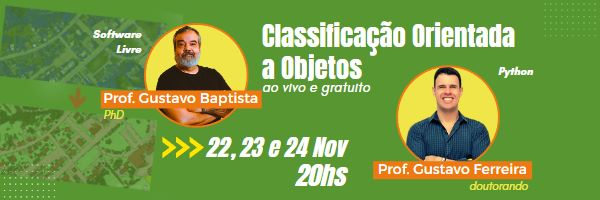

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Instalando bibliotecas necessárias

In [ ]:
!pip install -q geopandas
!pip install -q rasterio

     |████████████████████████████████| 1.0 MB 9.1 MB/s 
     |████████████████████████████████| 16.7 MB 54.6 MB/s 
     |████████████████████████████████| 6.3 MB 62.6 MB/s 
     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [ ]:
# Execute essa célula para evitar erro na geopandas
# Pode ser necessário reiniciar o ambiente após instalação
!pip uninstall rtree
!sudo apt install libspatialindex-dev
!pip install rtree

# Importando bibliotecas e lendo arquivos

In [ ]:
# Importando bibliotecas
import numpy as np
from osgeo import gdal, ogr
from skimage import exposure
from skimage.segmentation import felzenszwalb, slic, quickshift, mark_boundaries
import rasterio as rio
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.ensemble import RandomForestClassifier
import tifffile as tif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Lendo imagem como array
src = rio.open('/content/drive/MyDrive/Dados_PDI/CUBO_GEOBIA.tif')

list_band = [src.read(i+1) for i in range(src.count)]

img = np.dstack(list_band)

In [ ]:
# Armazenando metadados
meta = src.profile

# Segmentando imagem

In [ ]:
# Reamostrando para valores de -1 a 1
img2 = exposure.rescale_intensity(img)

In [ ]:
#segments = quickshift(img2[:,:,12:15].astype('double'), kernel_size=5, max_dist=1000, ratio=0.1)
#segments = slic(img2, n_segments=10000, compactness=0.1, sigma=0, start_label=1)

In [ ]:
# Criando segmentos
segments = felzenszwalb(img2, scale=1, sigma=1, min_size=70)

In [ ]:
# Gravando segmentos em disco
meta.update({'count': 1})
with rio.open('segments.tif', 'w', **meta) as src:
    src.write(segments,1)

In [ ]:
#Função de expansão
def expansao(img, percent_ini=2, percent_fim=98):
    s = np.zeros_like(img)
    x,y = 0,1  
    w = np.percentile(img, percent_ini)
    z = np.percentile(img, percent_fim)        
    p = x + (img - w) * (y - x) / (z - w)    
    p[p<x] = x
    p[p>y] = y
    s = p
    return s

In [ ]:
# Visualizando segmentos
plt.figure(figsize=(15,10))
plt.imshow(mark_boundaries(expansao(img[:,:,7]), segments))

In [ ]:
# Função para poligonizar raster
def polygonize(raster_file):
  img = gdal.Open(raster_file)
  dn = img.GetRasterBand(1)
  shp_driver = ogr.GetDriverByName("ESRI Shapefile")

  shape_out = shp_driver.CreateDataSource('segs.shp')
  srs = ogr.osr.SpatialReference()
  srs.ImportFromEPSG(32723)
  novo_shape = shape_out.CreateLayer('segs.shp', srs = srs)
  gdal.Polygonize(dn, None, novo_shape, -1, [], callback=None)
  shape_out.Destroy()
  return print('Polígonos criados!')

In [ ]:
polygonize('/content/segments.tif')

# Criando regiões de interesse

In [ ]:
# Função para criação de ROI
def roi_create(pol_file, pts_file):
  pol = gpd.read_file(pol_file)
  pts = gpd.read_file(pts_file)
  join_df = pts.sjoin(pol, how="right")
  res = join_df.query("amostras >= 1")
  res.to_file('roi_f.shp')
  print('ROI criada!')
  return res

In [ ]:
roi_f = roi_create('/content/segs.shp', '/content/drive/MyDrive/Dados_PDI/roi_seg.shp')

In [ ]:
# Visualizando ROI
roi_f.plot(column='amostras', figsize=(12,8))

# Extraindo atributos

In [ ]:
# Função para extração de estatísticas
def describe(arr):
  mean = np.mean(arr)
  median = np.median(arr)
  min = np.min(arr)
  max = np.max(arr)
  range = np.ptp(arr)
  var = np.var(arr)
  sd = np.std(arr)
  return [mean, median, sd, min,max,var,range]


In [ ]:
# Função para cálculo de estatísticas por segmentos
def features(pixels_seg):
    feat = []
    pixels, bandas = pixels_seg.shape
    for i in range(bandas):
        stats = describe(pixels_seg[:, i])
        stat_bandas = list(stats) 
        
        feat += stat_bandas
    return feat

In [ ]:
# Função para criar objetos com identificadores
def get_ids(seg):
  segment_ids = np.unique(segments)
  obj = []
  obj_id = []
  for id in segment_ids:
      segment_pixels = img[segments == id]
      object_features = features(segment_pixels)
      obj.append(object_features)
      obj_id.append(id)
  return obj, obj_id,segment_ids

In [ ]:
obj, obj_id,segment_ids = get_ids(segments)

# Criando conjunto de treino e teste

In [ ]:
# Função para criação de conjuntos de treino e teste
def train_test_set(file):

  gdf = gpd.read_file(file)

  classes = gdf['amostras'].unique()

  classes_ids = np.arange(classes.size) + 1

  gdf['amostras'] = gdf['amostras'].map(dict(zip(classes, classes_ids)))

  gdf_train = gdf.sample(frac=0.7,random_state=377)
  gdf_test = gdf.drop(gdf_train.index)
  gdf_train.to_file('train.shp')
  gdf_test.to_file('test.shp')

In [ ]:
train_test_set('/content/roi_f.shp')

In [ ]:
# Função para rasterizar polígonos
def rasterize(raster, shp):

  raster_input = gdal.Open(raster)

  vec_shp = ogr.Open(shp)
  layer = vec_shp.GetLayer()

  driver = gdal.GetDriverByName('MEM')
  rasterized = driver.Create('', raster_input.RasterXSize, raster_input.RasterYSize, 1, gdal.GDT_UInt16)
  rasterized.SetGeoTransform(raster_input.GetGeoTransform())
  rasterized.SetProjection(raster_input.GetProjection())

  gdal.RasterizeLayer(rasterized, [1], layer, options=['ATTRIBUTE=amostras'])
  result = rasterized.GetRasterBand(1).ReadAsArray()
  return result

In [ ]:
roi = rasterize('/content/drive/MyDrive/Dados_PDI/CUBO_GEOBIA.tif', 'train.shp')

# Rodando classificação

In [ ]:
# Criaçao de X e y para o Random Forests
classes = np.unique(roi)[1:]

segs_class = {}

for i in classes:
  class_segments = segments[roi == i]
  segs_class[i] = list(class_segments)

train_img = np.copy(segments)

train_obj = []
train_rot = []

for k in classes:
  atri_train_obj = []
  for i, j in enumerate(obj):
    if segment_ids[i] in segs_class[k]:
      atri_train_obj.append(j)
  train_rot += [k] * len(atri_train_obj)
  train_obj += atri_train_obj

In [ ]:
# Classificando objetos
rf = RandomForestClassifier(n_estimators= 500, max_depth=1000, n_jobs=-1)
rf.fit(train_obj, train_rot)

pred = rf.predict(obj)


classified = np.copy(segments)
for i, j in zip(segment_ids, pred):
    classified[classified == i] = j

# Gravando em disco
with rio.open('classified.tif', 'w', **meta) as src:
    src.write(classified,1)

In [ ]:
# Criação de rampa de cores
cmap = colors.ListedColormap(['#3380d8', '#015721','#fcf7f0','#f58500','#1df209','#ff0101'])

In [ ]:
# Visualizando resultado
classs = tif.imread('classified.tif')
plt.figure(figsize=(15,10))
plt.imshow(classs, cmap=cmap)

# Avaliação de acurácia

In [ ]:
test = rasterize('/content/drive/MyDrive/Dados_PDI/CUBO_GEOBIA.tif', 'test.shp')

In [ ]:
# Classification report
index = np.nonzero(test)

print(classification_report(test[index], classified[index]))

In [ ]:
# Matriz de confusão
confusion_matrix(test[index], classified[index])

# Off-topic

In [ ]:
!pip install -q qrcode

In [ ]:
import qrcode
qrcode.make('https://www.geosensor.com.br/pdi')